## Rolling circle spike filtering

In [1]:
%matplotlib inline

import os
import sys
notebook_path = os.path.abspath('.')
sources_path = os.path.abspath(os.path.join(notebook_path, '..'))
sys.path.insert(0, sources_path)

import matplotlib.pylab as plt
import numpy as np
import torch
import logging
import pickle

from skimage.filters import threshold_otsu

from cellmincer.opto_ws import \
    OptopatchBaseWorkspace, \

from cellmincer.opto_utils import \
    rolling_circle_filter_np, \
    rolling_circle_filter_torch \

device = torch.device("cuda")
dtype = torch.float32

def new_fig(figsize=(15, 5)):
    fig = plt.figure(figsize=figsize)
    ax = plt.gca()
    return fig, ax

logger = logging.getLogger()
log_info = logger.warning

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = False

In [2]:
# names
opto_mov_prefixes = [
    'D1_FOV3_W2_at135105',
    'D4_FOV2_W2_at171603',
    'D4_FOV3_W2_at172029',
    'E3_FOV1_W2_at155440',
    'F1_FOV2_W1_at143005'
]

model_prefix = 'rc1'
denoised_opto_mov_path_list = [
    f'/home/jupyter/mb-ml-dev-disk/data/Optopatch/denoised_data/{prefix}__{model_prefix}__denoised.npy'
    for prefix in opto_mov_prefixes]

output_path = '/home/jupyter/mb-ml-dev-disk/data/Optopatch/spike_data'

if not os.path.exists(output_path):
    os.mkdir(output_path)

In [ ]:
# frame-to-frame time difference (in units of s)
dt = 0.002

# circle radius in time (x) direction (in units of s)
radius_time = 0.02

# circle radius in amplitude (y) direction
radius_amplitude = 1.0

In [3]:
i_dataset = 0
ws_base = OptopatchBaseWorkspace.from_npy(denoised_opto_mov_path_list[i_dataset], permutation=(0, 2, 1))

Loading movie from /home/jupyter/mb-ml-dev-disk/data/Optopatch/denoised_data/D1_FOV3_W2_at135105__dejitter_test_gp__denoised.npy ...


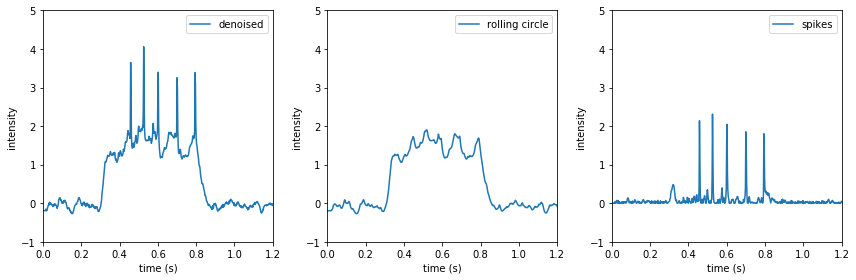

In [53]:
viz_pixels = [(393, 65), (490, 126)]

i_viz = 1
x0, y0 = viz_pixels[i_viz]

t = dt * np.arange(0, ws_base.n_frames)
raw_trace_t = ws_base.movie_txy[:, x0, y0]
bg_trace_t = rolling_circle_filter_np(
    t, raw_trace_t, radius_x=radius_time, radius_y=radius_amplitude)

fig, axs = plt.subplots(ncols=3, figsize=(12, 4))

axs[0].plot(t, raw_trace_t, label='denoised')
axs[0].set_xlim((0, 1.2))
axs[0].set_ylim((-1, 5))
axs[0].legend()
axs[0].set_xlabel('time (s)')
axs[0].set_ylabel('intensity')

axs[1].plot(t, bg_trace_t, label='rolling circle')
axs[1].set_xlim((0, 1.2))
axs[1].set_ylim((-1, 5))
axs[1].legend()
axs[1].set_xlabel('time (s)')
axs[1].set_ylabel('intensity')

axs[2].plot(t, raw_trace_t - bg_trace_t, label='spikes') 
axs[2].set_xlim((0, 1.2))
axs[2].set_ylim((-1, 5))
axs[2].legend()
axs[2].set_xlabel('time (s)')
axs[2].set_ylabel('intensity')

plt.tight_layout()
# plt.savefig('./out/spikes_rolling_circle_2.pdf')

In [54]:
t = torch.tensor(dt * np.arange(0, ws_base.n_frames), device=device, dtype=dtype)
raw_trace_xyt = torch.tensor(ws_base.movie_txy.transpose(-2, -1, -3), device=device, dtype=dtype)
bg_trace_xyt = rolling_circle_filter_torch(
    t, raw_trace_xyt,
    radius_x=radius_time,
    radius_y=radius_amplitude,
    log_progress=True,
    log_every=500)

processing 0 / 5400 ...
processing 500 / 5400 ...
processing 1000 / 5400 ...
processing 1500 / 5400 ...
processing 2000 / 5400 ...
processing 2500 / 5400 ...
processing 3000 / 5400 ...
processing 3500 / 5400 ...
processing 4000 / 5400 ...
processing 4500 / 5400 ...
processing 5000 / 5400 ...


In [55]:
spike_txy = (raw_trace_xyt.cpu().numpy() - bg_trace_xyt.cpu().numpy()).transpose(-1, -3, -2)

## Make spike movie

In [65]:
import skvideo
from skvideo import io as skio
from matplotlib.colors import Normalize

In [66]:
norm = Normalize(vmin=0, vmax=8., clip=True)
denoised_movie_txy = (255 * norm(spike_txy)[..., None])

movie_out_path = os.path.join(
    output_path,
    opto_mov_prefixes[i_dataset] + "__" + model_prefix + "__median_filter_order_5.avi")

writer = skio.FFmpegWriter(
    movie_out_path,
    outputdict={'-vcodec': 'rawvideo', '-pix_fmt': 'yuv420p', '-r': '60'})

for i in range(4200, 4900):
        writer.writeFrame(denoised_movie_txy[i, ...].T)
writer.close()